<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, flat_field step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and flat_field validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS), [IFU test](#IFU) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [7]:
import os
import subprocess
from astropy.io import fits

from jwst.flatfield.flat_field_step import FlatFieldStep

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/requirements.txt

# import NPTT
import nirspec_pipe_testing_tool as nptt


In [2]:
# Make sure that the version used is the right one

# to get the latest version from 'master' run:
# subprocess.run(['pip', 'install', 'git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@master'])

latest_nptt_stable_version = '1.1.1'
nptt_version = nptt.__version__

if nptt_version != latest_nptt_stable_version:
    print("* WARNING - The code might break because the version used is not the latest stable version:")
    print("            Latest stable version is ", latest_nptt_stable_version)
    print("            Using NPTT version ", nptt_version)

* WARNING - The code might break because the version used is not the latest stable version:
            Latest stable version is  1.1.1
            Using NPTT version  1.1.1.dev4+gb2081e9


<a id="intro_ID"></a>
# Introduction

The test is a direct comparison of the result of our implementation of the flat field step algorithm versus the pipeline's implementation, i.e.: 
              difference =  absolute( Flat_nirspec_implementation - Flat_pipeline)

We expect the absolute difference to be of the order of 1x10^-6. We set this threshold by assuming that the difference should yield computer precision 1x10^-7 numbers. We then relaxed one order of magnitude due to interpolation differences in the algorithms.

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_fs.py. For Multi Object Spectroscopy (MOS), the code is in the same repository but is named ```flattest_mos.py```, and for Integral Field Unit (IFU) data, the test is named ```flattest_ifu.py```.

The input file is defined in the variable ```input_file``` (see section [Testing Data Set and Variable Setup](#data_ID)).

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/main.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/flatfield


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+Flat+Field+Correction


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing:
- FS_FULLFRAME_G395H_F290LP
- FS_ALLSLITS_G140H_F100LP 
- MOS_G140M_LINE1 
- IFU_G395H_F290LP 

The testing data can be located at ```path_to_nirspec_vault/prelaunch_data/testing_sets/b7.1_pipeline_testing/test_data_suite```

In that directory you will find a subdirectory for CV3 data for FS, MOS, and IFU, as well as other campaigns. This notebook is specifically written for CV3 data.


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and assign_wcs validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the flat_field step, use the command:

$ strun jwst.flat_field.FlatFieldStep jwtest_extract_2d.fits

These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.flat_field.flat_field_step import FlatFieldStep
 
$\gt$ FlatFieldStep.call(jwtest_extract_2d.fits)

For the imaging pipeline the call would be as follows:

$\gt$ from jwst.pipeline.calwebb_image2 import Image2Pipeline

$\gt$ Image2Pipeline.call(jwtest_rate.fits)

NPTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use NPTT to run the pipeline and the validation tests. To run NPTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

-> For each mode, the following variables will need to be set:
- output_directory = string, path where you want intermediary files and plots to be saved in, if writefile=True
- input_file = string or object, this is the output file from the previous step, e.g. jwtest1_NRS1_extract2d.fits
- dflat_path = string, path of where the D-flat reference fits files
- sflat_path = string, path of where the S-flat reference fits files
- fflat_path = string, path of where the F-flat reference fits files
- writefile = boolean, if True writes the fits files of the calculated flat, and the difference jpeg images
- save_figs = boolean, whether to save plots or not
- show_figs = boolean, whether to show plots or not 
- threshold_diff = float, threshold difference between pipeline output and ESA file


<a id="common_vars"></a>
# Common Variables

In [3]:
# Set common variables for entire notebook

# paths
WIT4_PATH = os.environ.get('WIT4_PATH')
flats_path = os.path.join(WIT4_PATH, 'nirspec/CDP3/04_Flat_field')
dflat_path = os.path.join(flats_path, '4.2_D_Flat/nirspec_dflat')
vault_path = os.path.join(WIT4_PATH, 'nirspec_vault')
test_data_path = '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data'

# accepted threshold difference with respect to benchmark files
threshold_diff = 9.999e-5

# other variable
writefile = False
save_figs = False
show_figs = True


<a id="FULLFRAME"></a>
# FS FULL-FRAME test

In [4]:
# Set the variables for Fixed Slit (FS) data
output_directory = os.path.join(test_data_path, 'FS_FULL_FRAME/G140M_opaque')
input_file = os.path.join(output_directory, 'gain_scale_NRS1_extract_2d.fits')
sflat_path = os.path.join(flats_path, '4.3_S_Flat/FS/nirspec_FS_sflat')
fflat_path = os.path.join(flats_path, '4.1_F_Flat/FS/nirspec_FS_fflat')


In [8]:
# Run the pipeline step
pipe_result = input_file.replace("extract_2d.fits", "flat_field.fits")
FlatFieldStep.call(input_file, output_file=pipe_result, save_interpolated_flat=True)


2020-09-25 12:26:08,048 - CRDS - ERROR -  Error determining best reference for 'pars-flatfieldstep'  =   Unknown reference type 'pars-flatfieldstep'
2020-09-25 12:26:08,050 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2020-09-25 12:26:08,153 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args ('/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/gain_scale_NRS1_extract_2d.fits',).
2020-09-25 12:26:08,155 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/gain_scale_NRS1_flat_field.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': True}
2020-09-25 12:26:12,934 - stpipe.FlatF

<MultiSlitModel from gain_scale_NRS1_flatfieldstep.fits>

In [9]:
# Move the output files to the output directory
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'flatfieldstep.fits'), pipe_result])
interpolated_flat = input_file.replace("extract_2d.fits", "interpolatedflat.fits")
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'interpolatedflat.fits'), interpolated_flat])

CompletedProcess(args=['mv', 'gain_scale_NRS1_interpolatedflat.fits', '/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/gain_scale_NRS1_interpolatedflat.fits'], returncode=0)

step_input_filename=/Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/gain_scale_NRS1_flat_field.fits
flat_field_file  -->     Grating:G140M   Filter:F100LP   LAMP:LINE1
Using D-flat: /grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.2_D_Flat/nirspec_dflat_nrs1_f_01.03.fits
Using S-flat: /grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.3_S_Flat/FS/nirspec_FS_sflat_G140M_OPAQUE_FLAT1_nrs1_f_01.01.fits
Using F-flat: /grp/jwst/wit4/nirspec/CDP3/04_Flat_field/4.1_F_Flat/FS/nirspec_FS_fflat_F100LP_01.01.fits
Now looping through the slits. This may take a while... 
Filename: /Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/gain_scale_NRS1_interpolatedflat.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     273   ()      
  1  SCI           1 ImageHDU        14   (1382, 48)   float32   
  2  DQ            1 ImageHDU        11   (1382, 48)   int32 (rescales to uint

2020-09-25 12:29:29,848 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_fs.py:566: RuntimeWarning: invalid value encountered in less
  in_slit = np.logical_and(difference_img < 900.0,

2020-09-25 12:29:29,849 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/flattest_fs.py:567: RuntimeWarning: invalid value encountered in greater
  difference_img > -900.0)  # ignore points out of the slit,



Calculating statistics... 

   Absolute Flat Difference  :   mean = 8.209e-07    median = -1.729e-07    stdev = 2.439e-04
    Maximum   AbsoluteFlat Difference = 1.466e-03
    Minimum   AbsoluteFlat Difference = -1.822e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 58%
                            ->  3xtheshold = 18%
                            ->  5xtheshold = 5%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!

 *** Result of the test: PASSED



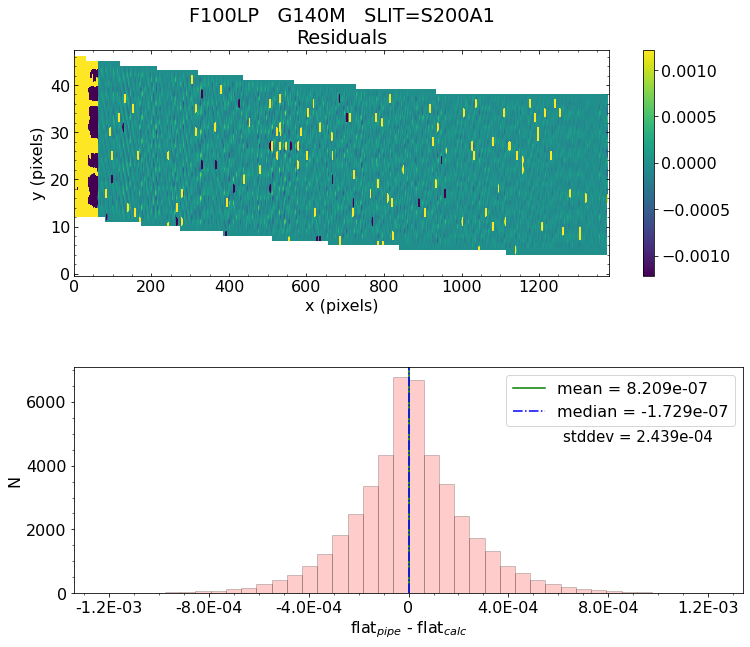


Working with slit: S200A2
exp_type =  NRS_FIXEDSLIT
SCI ext =  2
Filename: /Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/gain_scale_NRS1_flat_field.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     289   ()      
  1  SCI           1 ImageHDU        56   (1382, 48)   float32   
  2  DQ            1 ImageHDU        11   (1382, 48)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU        10   (1382, 48)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (1382, 48)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (1382, 48)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (1382, 48)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (1382, 48)   float32   
  8  SCI           2 ImageHDU        56   (1466, 50)   float32   
  9  DQ            2 ImageHDU        11   (1466, 50)   int32 (rescales to uint32)   
 10  ERR           2 ImageHDU        10   (1466, 50

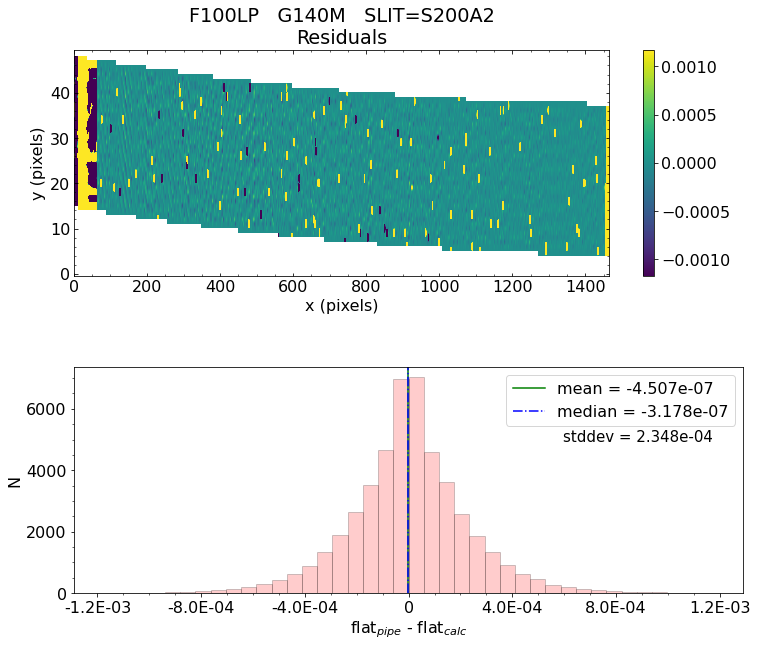


Working with slit: S400A1
exp_type =  NRS_FIXEDSLIT
SCI ext =  3
Filename: /Users/pena/Documents/PyCharmProjects/nirspec/pipeline/testing_data/FS_FULL_FRAME/G140M_opaque/gain_scale_NRS1_flat_field.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     289   ()      
  1  SCI           1 ImageHDU        56   (1382, 48)   float32   
  2  DQ            1 ImageHDU        11   (1382, 48)   int32 (rescales to uint32)   
  3  ERR           1 ImageHDU        10   (1382, 48)   float32   
  4  WAVELENGTH    1 ImageHDU         9   (1382, 48)   float32   
  5  VAR_POISSON    1 ImageHDU         9   (1382, 48)   float32   
  6  VAR_RNOISE    1 ImageHDU         9   (1382, 48)   float32   
  7  VAR_FLAT      1 ImageHDU         9   (1382, 48)   float32   
  8  SCI           2 ImageHDU        56   (1466, 50)   float32   
  9  DQ            2 ImageHDU        11   (1466, 50)   int32 (rescales to uint32)   
 10  ERR           2 ImageHDU        10   (1466, 50

In [ ]:
# Run the validation test
%matplotlib inline
result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_fs.flattest(pipe_result,
                                                                                                   dflat_path=dflat_path,
                                                                                                   sflat_path=sflat_path, 
                                                                                                   fflat_path=fflat_path,
                                                                                                   writefile=writefile,
                                                                                                   show_figs=show_figs, 
                                                                                                   save_figs=save_figs,
                                                                                                   plot_name=None,
                                                                                                   threshold_diff=threshold_diff,
                                                                                                   output_directory=output_directory, 
                                                                                                   debug=False)


In [ ]:
# Quickly see if the test passed 
   
print("Did flat_field validation for FS FULL-FRAME test passed? ", result_msg)


<a id="ALLSLITS"></a>
# FS ALLSLITS test

In [ ]:
# Set the variables 
output_directory = os.path.join(test_data_path, 'FS_ALLSLITS/G235M_F170LP')
input_file = os.path.join(output_directory, 'final_output_caldet1_NRS1_extract_2d.fits')
sflat_path = os.path.join(flats_path, '4.3_S_Flat/FS/nirspec_FS_sflat')
fflat_path = os.path.join(flats_path, '4.1_F_Flat/FS/nirspec_FS_fflat')


In [ ]:
# Run the pipeline step
pipe_result = input_file.replace("extract_2d.fits", "flat_field.fits")
FlatFieldStep.call(input_file, output_file=pipe_result, save_interpolated_flat=True)

In [ ]:
# Move the output files to the output directory
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'flatfieldstep.fits'), pipe_result])
interpolated_flat = input_file.replace("extract_2d.fits", "interpolatedflat.fits")
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'interpolatedflat.fits'), interpolated_flat])

In [ ]:
# Run the validation test
%matplotlib inline
result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_fs.flattest(pipe_result,
                                                                                              dflat_path=dflat_path,
                                                                                              sflat_path=sflat_path, 
                                                                                              fflat_path=fflat_path,
                                                                                              writefile=writefile,
                                                                                              show_figs=show_figs, 
                                                                                              save_figs=save_figs,
                                                                                              plot_name=None,
                                                                                              threshold_diff=threshold_diff,
                                                                                              output_directory=output_directory, 
                                                                                              debug=False)

In [ ]:
# Quickly see if the test passed 
   
print("Did flat_field validation test for FS ALLSLITS passed? ", result_msg)


<a id="MOS"></a>
# MOS test

In [ ]:
# Set the variables 
output_directory = os.path.join(test_data_path, 'MOS/G140M_LINE1')
msa_shutter_conf = os.path.join(output_directory,'V8460001000101_new_msa.fits')
input_file = os.path.join(output_directory, 'final_output_caldet1_NRS1_extract_2d.fits')
sflat_path = os.path.join(flats_path, '4.3_S_Flat/MOS/nirspec_MOS_sflat')
fflat_path = os.path.join(flats_path, '4.1_F_Flat/MOS/nirspec_MOS_fflat')


In [ ]:
# Run the pipeline step
pipe_result = input_file.replace("extract_2d.fits", "flat_field.fits")
FlatFieldStep.call(input_file, output_file=pipe_result, save_interpolated_flat=True)

In [ ]:
# Move the output files to the output directory
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'flatfieldstep.fits'), pipe_result])
interpolated_flat = input_file.replace("extract_2d.fits", "interpolatedflat.fits")
subprocess.run(['mv', os.path.basename(input_file).replace('extract_2d.fits', 'interpolatedflat.fits'), interpolated_flat])

In [ ]:
# Run the validation test
%matplotlib inline
result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_mos.flattest(pipe_result,
                                                                                               dflat_path=dflat_path,
                                                                                               sflat_path=sflat_path, 
                                                                                               fflat_path=fflat_path,
                                                                                               msa_shutter_conf=msa_shutter_conf,     
                                                                                               writefile=writefile,
                                                                                               show_figs=show_figs, 
                                                                                               save_figs=save_figs,
                                                                                               plot_name=None,
                                                                                               threshold_diff=threshold_diff,
                                                                                               debug=False)


In [ ]:
# Quickly see if the test passed 
   
print("Did flat_field validation for MOS test passed? ", result_msg)


<a id="IFU"></a>
# IFU test

In [ ]:
# Set the variables 
output_directory = os.path.join(test_data_path, 'IFU_CV3/G395H_OPAQUE')
# IFU does not do the extract_2d step
input_file = os.path.join(output_directory, 'final_output_caldet1_NRS2_assign_wcs.fits')  
sflat_path = os.path.join(flats_path, '4.3_S_Flat/IFU/nirspec_IFU_sflat')
fflat_path = os.path.join(flats_path, '4.1_F_Flat/IFU/nirspec_IFU_fflat')


In [ ]:
# Run the pipeline step
pipe_result = input_file.replace("assign_wcs.fits", "flat_field.fits")
FlatFieldStep.call(input_file, output_file=pipe_result, save_interpolated_flat=True)

In [ ]:
# Move the output files to the output directory
subprocess.run(['mv', os.path.basename(input_file).replace('assign_wcs.fits', 'flatfieldstep.fits'), pipe_result])
interpolated_flat = input_file.replace("assign_wcs.fits", "interpolatedflat.fits")
subprocess.run(['mv', os.path.basename(input_file).replace('assign_wcs.fits', 'interpolatedflat.fits'), interpolated_flat])

In [ ]:
# Run the validation test
%matplotlib inline
result, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.flattest_ifu.flattest(pipe_result,
                                                                                              dflat_path=dflat_path,
                                                                                              sflat_path=sflat_path, 
                                                                                              fflat_path=fflat_path,
                                                                                              writefile=writefile,
                                                                                              mk_all_slices_plt=False, 
                                                                                              show_figs=show_figs, 
                                                                                              save_figs=save_figs,
                                                                                              plot_name=None,
                                                                                              threshold_diff=threshold_diff,
                                                                                              debug=False)


In [ ]:
# Quickly see if the test passed 
   
print("Did flat_field validation test for IFU passed? ", result_msg)


<a id="results"></a>
## Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.

<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec
<br>**Updated On:** Sept/25/2020

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 